# Potato Disease Classification

Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

### Importing all the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

### Setting all the Constants

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

### Importing data into tensorflow dataset object using API

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "C:\\Users\\name\\Desktop\\ML\\Projects\\PotatoDiseaseClassification\\dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [ ]:
# Getting class names
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
# Visualizing the data
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels 

### Visualizing some of the images from our dataset

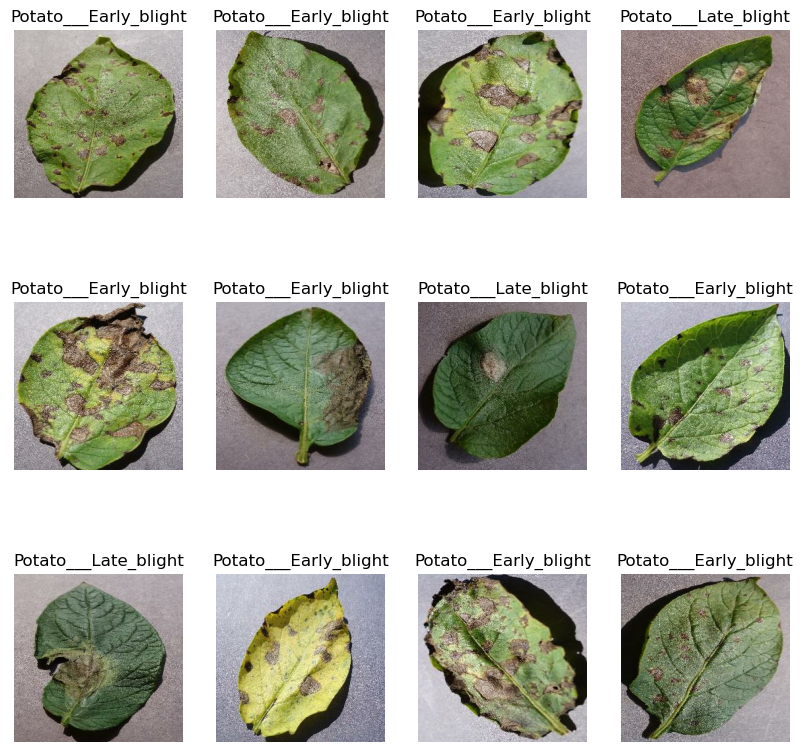

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset is subdevided into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [8]:
len(dataset)

68

In [ ]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [ ]:
# Creating the training dataset
train_ds = dataset.take(54)
len(train_ds)

54

In [11]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [12]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [ ]:
# Creating the validation dataset
val_ds = test_ds.take(6)
len(val_ds)

6

In [ ]:
# Creating the test dataset
test_ds = test_ds.skip(6)
len(test_ds)

8

In [16]:
# Splitting dataset function
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

54

In [19]:
len(val_ds)

6

In [20]:
len(test_ds)

8

### Cache, Shuffle, and Prefetch the Dataset

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before feeding the images to network, it should be resized to the desired size. 
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

Why the need to resize (256,256) image to again (256,256)?. We don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [24]:
# Resize + rescale
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [25]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [26]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

**I am using convolutional neural network (CNN) here. CNN is popular for image classification tasks.**

In [31]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    layers.Input(shape=input_shape),
    resize_and_rescale,
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [34]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [35]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [54]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.8715 - loss: 0.3306 - val_accuracy: 0.8333 - val_loss: 0.4646
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - accuracy: 0.9008 - loss: 0.2701 - val_accuracy: 0.9167 - val_loss: 0.2484
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.8932 - loss: 0.2829 - val_accuracy: 0.7917 - val_loss: 0.5185
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 169s 3s/step - accuracy: 0.8912 - loss: 0.2785 - val_accuracy: 0.8490 - val_loss: 0.3889
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 166s 3s/step - accuracy: 0.9313 - loss: 0.2198 - val_accuracy: 0.8490 - val_loss: 0.4077
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 167s 3s/step - accuracy: 0.9337 - loss: 0.2031 - val_accuracy: 0.8490 - val_loss: 0.3971
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 168s 3s/step - accuracy: 0.9343 - loss: 0.2023 - val_accuracy: 0.8958 - val_loss: 0.2575
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.8762 - loss: 0.3270 - val_accuracy: 0.9375 - v

In [55]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 749ms/step - accuracy: 0.9062 - loss: 0.2851


**The model has achieved 96.88% accuracy for our test dataset based on 30 epochs. This is considered to be a pretty good accuracy. With more epochs, the accuracy is expected to go higher.**

In [56]:
scores

[0.285132497549057, 0.90625]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [57]:
history

In [58]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [59]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [60]:
type(history.history['loss'])

list

In [61]:
len(history.history['loss'])

30

In [62]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.33059990406036377,
 0.2700737714767456,
 0.28293800354003906,
 0.27851739525794983,
 0.21984945237636566]

In [64]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

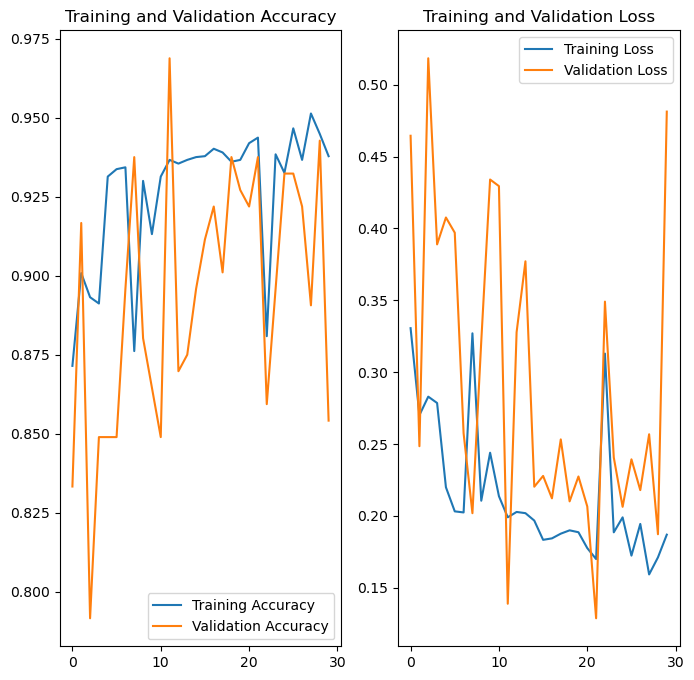

In [65]:
epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
predicted label: Potato___Early_blight


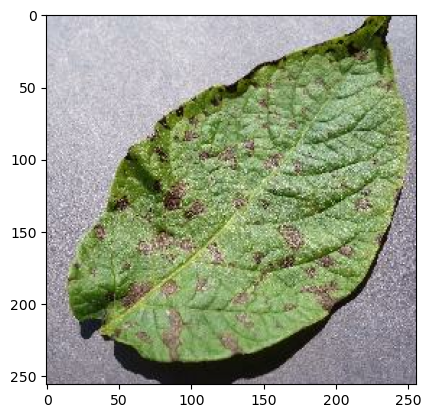

In [68]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [75]:
def predict(model, img):
    x = tf.convert_to_tensor(img)
    x = tf.expand_dims(x, 0)
    preds = model.predict(x, verbose=0)
    predicted_class = class_names[int(np.argmax(preds[0]))]
    confidence = round(100 * float(np.max(preds[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

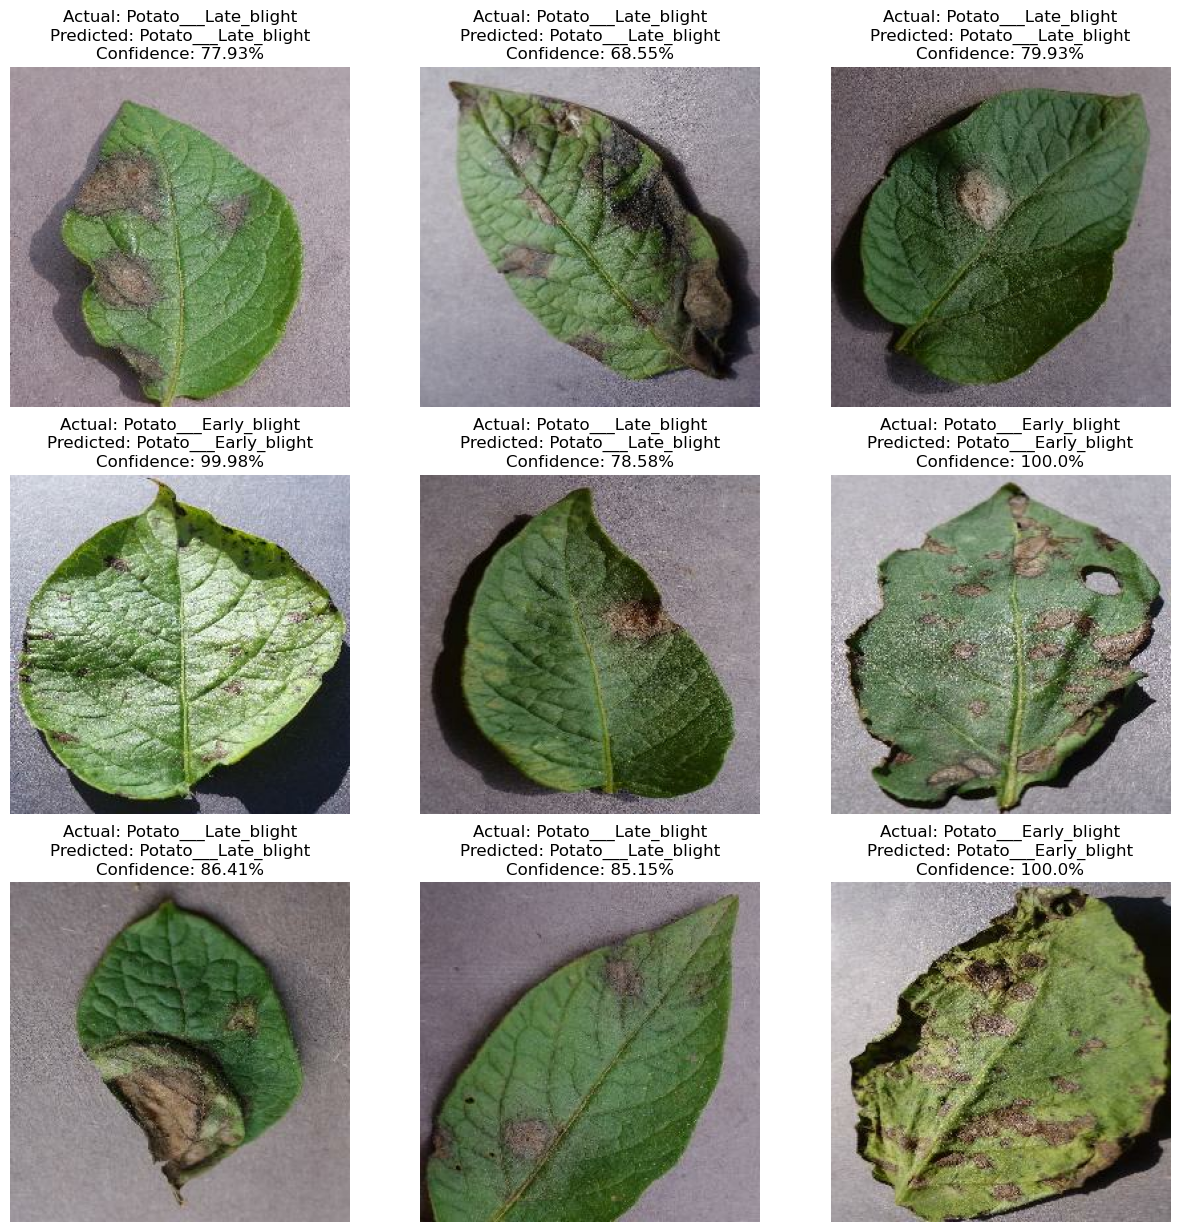

In [78]:

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(min(9, images.shape[0])):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[int(labels[i].numpy())]
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")


### Saving the Model
We append the model to the list of models as a new version

In [84]:

from pathlib import Path
export_dir = Path("../serving/potatoes_model/2")
export_dir.parent.mkdir(parents=True, exist_ok=True)
model.export(str(export_dir))
print("Exported:", export_dir.resolve())


INFO:tensorflow:Assets written to: ..\serving\potatoes_model\2\assets


INFO:tensorflow:Assets written to: ..\serving\potatoes_model\2\assets


Saved artifact at '..\serving\potatoes_model\2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_42')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1924264090448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1924264091408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1924264091216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1924264091792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1924264091600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1924264092176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1924264091984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1924264092560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1924264092368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1924264092944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1924264092752: Tenso

In [80]:
model_version=1
model.save("../models/potatoes.keras")